In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import PowerTransformer
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data Acquisition

In [9]:
orders_df = pd.read_csv(
    "https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/main/superstore/Superstore.csv",
    encoding='windows-1252'
)
orders_df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Data Pre-Processing

In [12]:
orders_df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [13]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [14]:
orders_df["Order Date"] = pd.to_datetime(orders_df["Order Date"])
orders_df["Ship Date"] = pd.to_datetime(orders_df["Ship Date"])
orders_df["Postal Code"] = orders_df["Postal Code"].astype(str)

## Feature Engineering

In [15]:
orders_df["Discount amount"] = orders_df["Sales"] * orders_df["Discount"]

In [20]:
main_df = orders_df.groupby(by="Customer ID", as_index=False).agg({
    "Order Date": "max",
    "Ship Mode": (lambda x: x.mode()[0]),
    "Segment": (lambda x: x.mode()[0]),
    "Category": (lambda x: x.mode()[0]),
    "Region": (lambda x: x.mode()[0]),
    "Order ID": "nunique",
    "Sales": "sum",
    "Discount amount": "sum"
})
main_df.head(5)

,Customer ID,Order Date,Ship Mode,Segment,Category,Region,Order ID,Sales,Discount amount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [21]:
main_df.columns = ["customer_id", "max_order_timestamp", "ship_mode", "type_customers", "category", "region", "frequency", "monetary", "discount"]
main_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720


In [22]:
main_df["max_order_timestamp"] = pd.to_datetime(main_df["max_order_timestamp"])
main_df["max_order_timestamp"] = main_df["max_order_timestamp"].dt.date
recent_date = orders_df["Order Date"].dt.date.max()
main_df["recency"] = main_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)
 
main_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415


# EDA

In [23]:
main_df.describe(include="all")

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency
count,793,793,793,793,793,793,793.000000,793.000000,793.000000,793.000000
unique,793,300,4,3,3,4,NaN,NaN,NaN,NaN
top,AA-10315,2017-12-02,Standard Class,Consumer,Office Supplies,East,NaN,NaN,NaN,NaN
freq,1,14,575,409,704,254,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.316520,2896.848500,406.787055,146.802018
std,NaN,NaN,NaN,NaN,NaN,NaN,2.550885,2628.670117,632.372871,186.211051
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.833000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1146.050000,102.691200,30.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,2256.394000,247.915600,75.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3785.276000,491.433300,183.000000


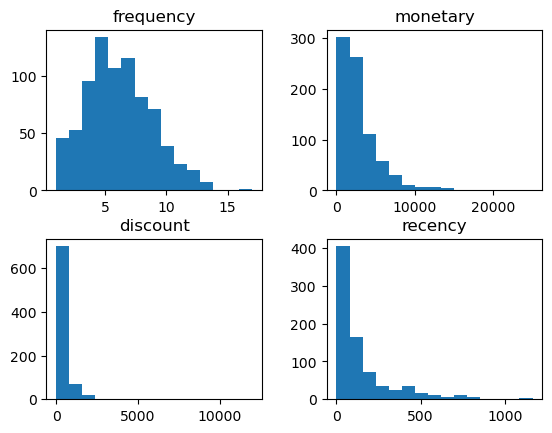

In [30]:
numerical = ["frequency", "monetary", "discount", "recency"]
main_df[numerical].hist(bins=15, grid=False)
plt.show()

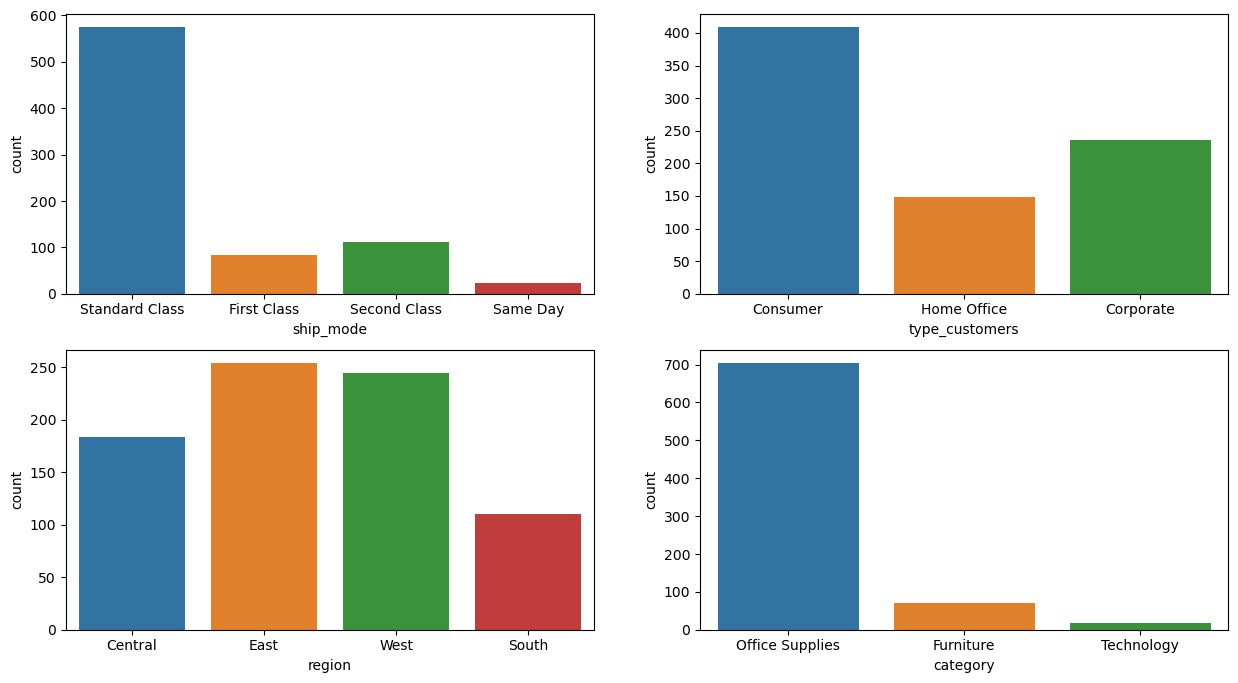

In [46]:
fig, ax = plt.subplots(ncols = 2, nrows = 2,figsize=(15,8))

sns.countplot(data=main_df, x='ship_mode', hue = 'ship_mode', ax=ax[0][0])
sns.countplot(data=main_df, x='type_customers', hue = 'type_customers', ax=ax[0][1])
sns.countplot(data=main_df, x='region', hue = 'region', ax=ax[1][0])
sns.countplot(data=main_df, x='category', hue = 'category', ax=ax[1][1])

plt.show()

## Distribution based on customers

In [47]:
def categorical_plot(features, df, segment_feature=None):
    fig, ax = plt.subplots(len(features), 1,figsize=(8,15))
    for i, feature in enumerate(features):
        if segment_feature:
            sns.countplot(data=df, x=segment_feature, hue=feature, ax=ax[i])
        else:
            sns.countplot(data=df, x=feature, ax=ax[i])
    plt.tight_layout()
    plt.show()

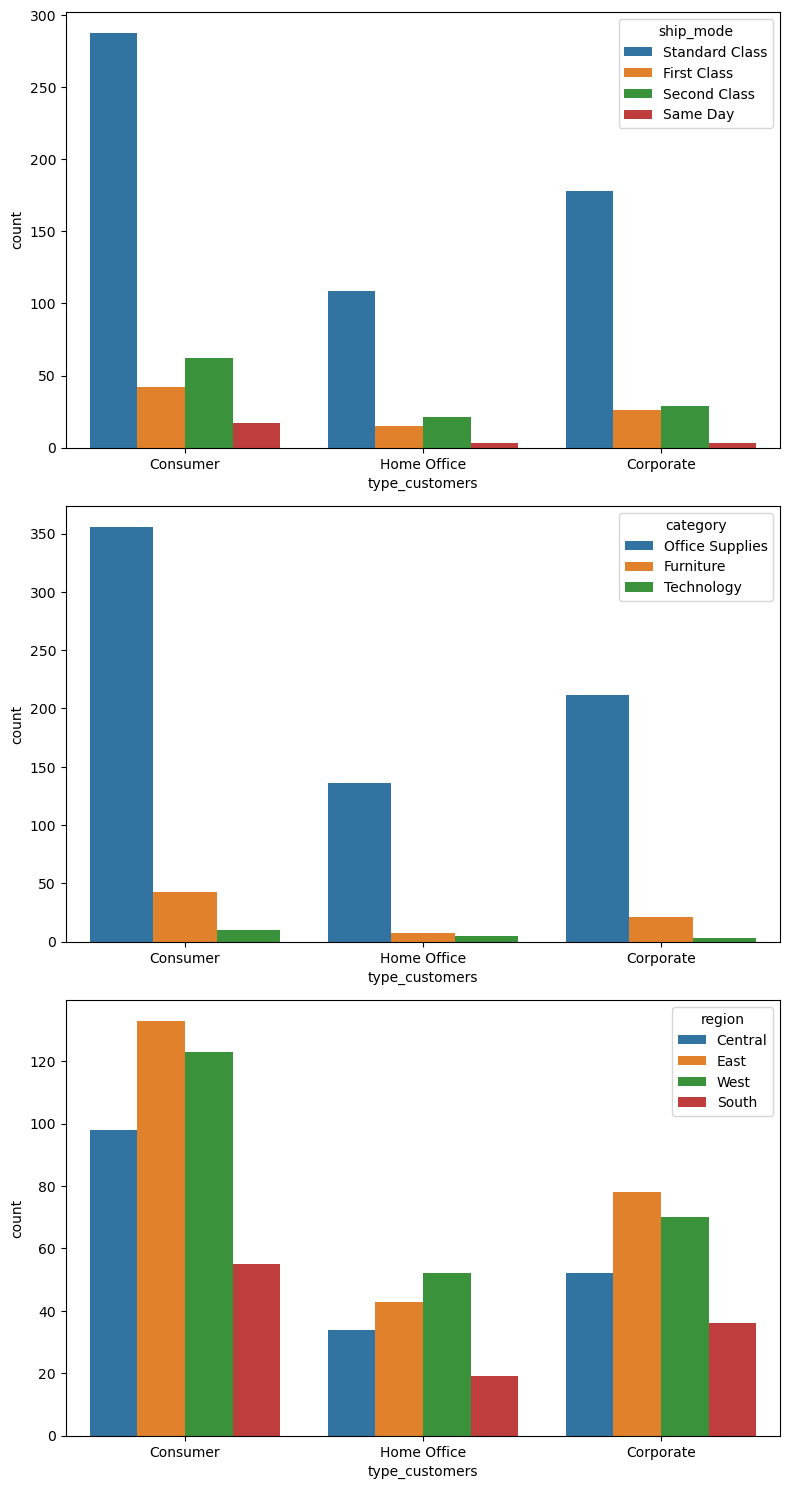

In [48]:
categorical_plot(
    features=["ship_mode", "category", "region"],
    df=main_df,
    segment_feature="type_customers"
)

## Distribution based on regions

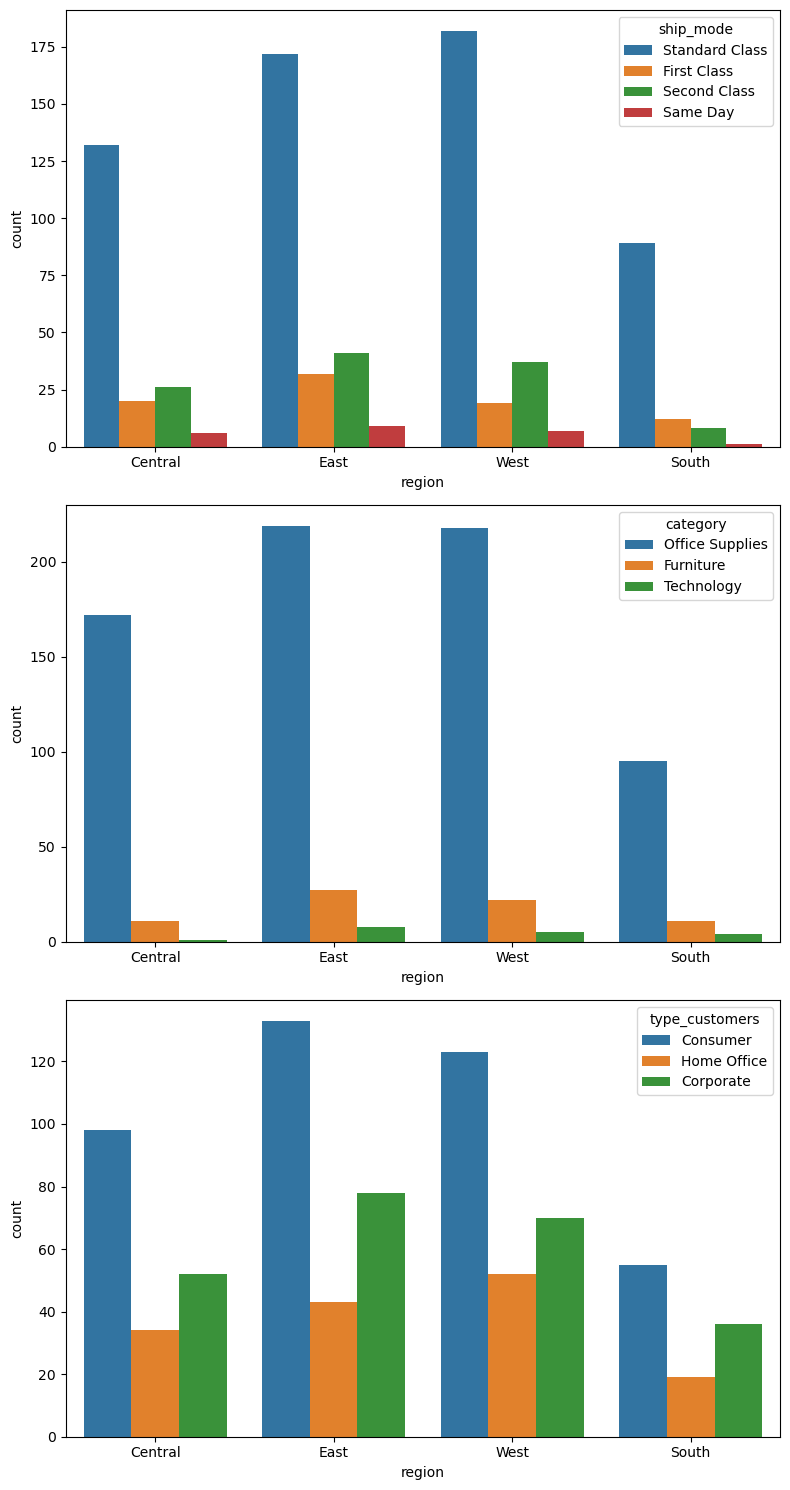

In [50]:
categorical_plot(
    features=["ship_mode", "category", "type_customers"],
    df=main_df,
    segment_feature="region"
)

In [62]:
def numerical_dis_plot(features, df, segment_feature=None, showfliers=True):
    fig, ax = plt.subplots(len(features), 1,figsize=(8,15))
    for i, feature in enumerate(features):
        if segment_feature:
            sns.boxplot(y=segment_feature, x=feature, data=df, hue = segment_feature, ax=ax[i], showfliers=showfliers)
            ax[i].set_ylabel(None)
        else:
            sns.boxplot(x=feature, data=df, ax=ax[i], showfliers=showfliers)
    plt.tight_layout()
    plt.show()

## Numerical distribtuions based on customer

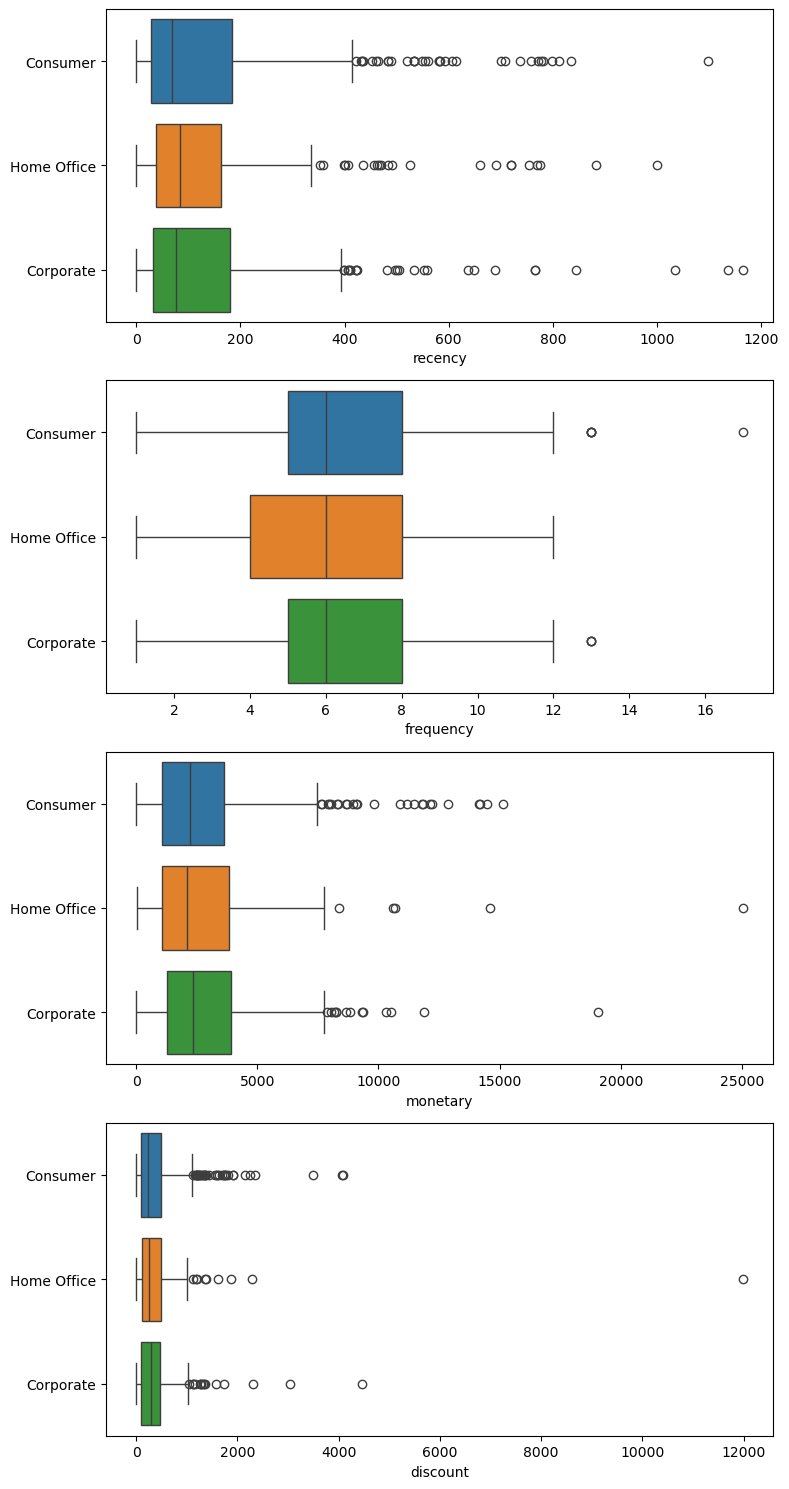

In [63]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=main_df, 
    segment_feature="type_customers"
)

## Numerical distribution based on regions

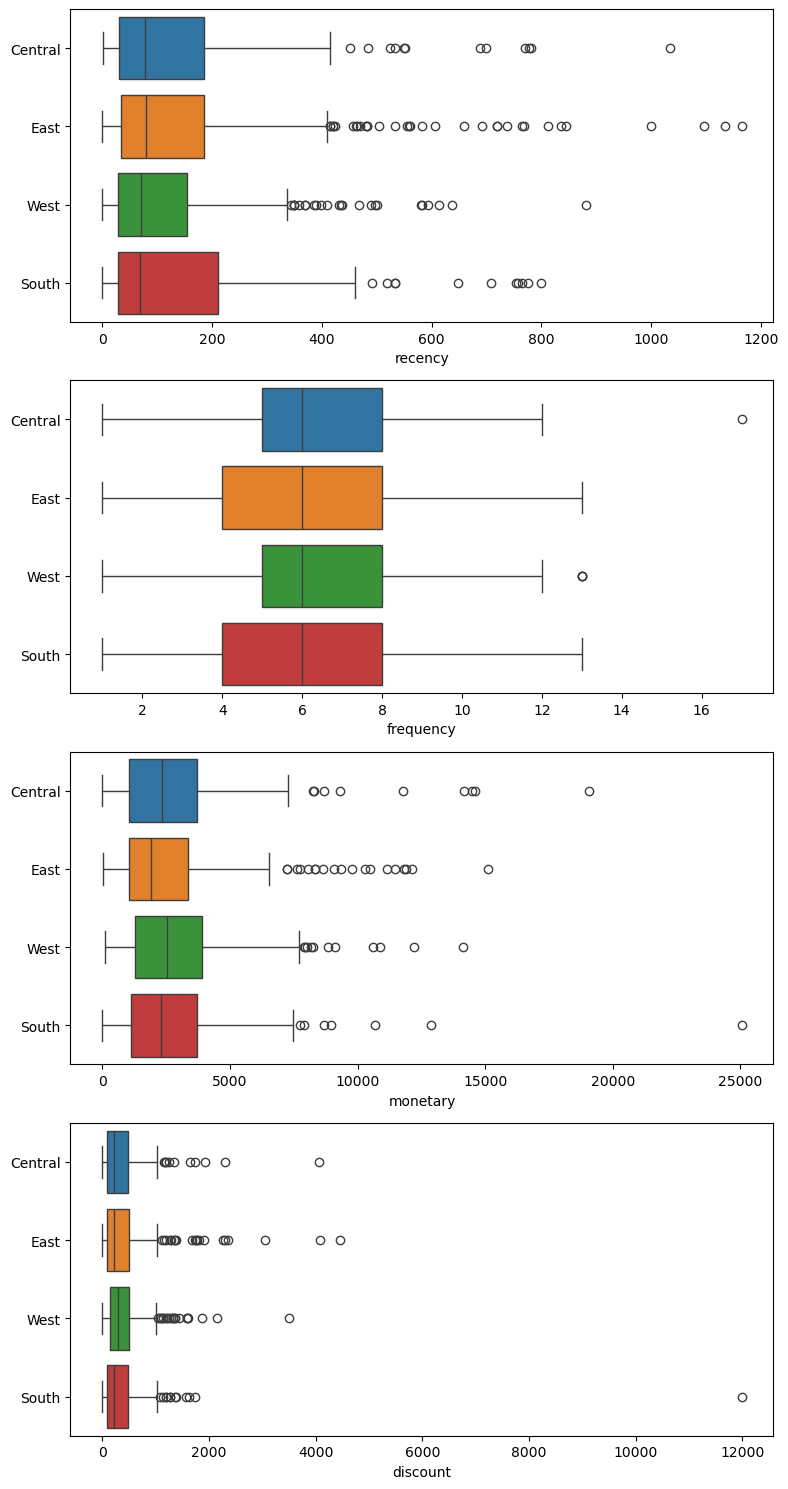

In [64]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=main_df, 
    segment_feature="region"
)

# RFM Analysis

In [65]:
rfm_df = main_df[["customer_id", "recency", "frequency", "monetary"]]
rfm_df.head()

,customer_id,recency,frequency,monetary
0,AA-10315,184,5,5563.560
1,AA-10375,19,9,1056.390
2,AA-10480,259,4,1790.512
3,AA-10645,55,6,5086.935
4,AB-10015,415,3,886.156


In [66]:
rfm_df['r_score'] = rfm_df['recency'].rank(ascending=False)
rfm_df['f_score'] = rfm_df['frequency'].rank(ascending=True)
rfm_df['m_score'] = rfm_df['monetary'].rank(ascending=True)

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/404274858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['r_score'] = rfm_df['recency'].rank(ascending=False)
/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/404274858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['f_score'] = rfm_df['frequency'].rank(ascending=True)
/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/404274858.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [67]:
rfm_df['r_score_norm'] = (rfm_df['r_score']/rfm_df['r_score'].max())*100
rfm_df['f_score_norm'] = (rfm_df['f_score']/rfm_df['f_score'].max())*100
rfm_df['m_score_norm'] = (rfm_df['m_score']/rfm_df['m_score'].max())*100

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/471182679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['r_score_norm'] = (rfm_df['r_score']/rfm_df['r_score'].max())*100
/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/471182679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['f_score_norm'] = (rfm_df['f_score']/rfm_df['f_score'].max())*100


In [70]:
rfm_df['RFM_score'] = (0.2*rfm_df['r_score_norm'] + 
                       0.3*rfm_df['f_score_norm'] + 
                       0.5*rfm_df['m_score_norm']) * 0.05
rfm_df.head(5)

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,r_score_norm,f_score_norm,m_score_norm,RFM_score
0,AA-10315,184,5,5563.560,195.5,262.5,702.0,24.699937,33.102144,88.524590,2.956646
1,AA-10375,19,9,1056.390,685.5,670.0,182.0,86.607707,84.489281,22.950820,2.707187
2,AA-10480,259,4,1790.512,140.0,147.5,323.0,17.687934,18.600252,40.731400,1.474168
3,AA-10645,55,6,5086.935,463.5,383.0,679.0,58.559697,48.297604,85.624212,3.450666
4,AB-10015,415,3,886.156,71.5,73.0,142.0,9.033481,9.205549,17.906683,0.676085


## Customer Segmentation (Rule Based)

In [73]:
rfm_df["customer_segment"] = np.where(
    rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.9), "Top customers", (np.where(
        rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.75), "High value customers", (np.where(
            rfm_df["RFM_score"] >= rfm_df["RFM_score"].quantile(0.25), "Medium value customers", "Low value customers"
        ))
    ))
)
rfm_df[['customer_id', 'RFM_score', 'customer_segment']].head(5)

,customer_id,RFM_score,customer_segment
0,AA-10315,2.956646,Medium value customers
1,AA-10375,2.707187,Medium value customers
2,AA-10480,1.474168,Low value customers
3,AA-10645,3.450666,High value customers
4,AB-10015,0.676085,Low value customers


In [74]:
result_rfm_df = pd.merge(
    left=main_df,
    right=rfm_df[["customer_id", "RFM_score", "customer_segment"]],
    on="customer_id",
    how="inner"
)
result_rfm_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency,RFM_score,customer_segment
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184,2.956646,Medium value customers
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19,2.707187,Medium value customers
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259,1.474168,Low value customers
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55,3.450666,High value customers
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415,0.676085,Low value customers


## Customer Segmentation (K-Means Clustering)

In [75]:
kmeans_df = main_df[["customer_id", "recency", "frequency", "monetary", "discount"]]
kmeans_df.head(5) 

,customer_id,recency,frequency,monetary,discount
0,AA-10315,184,5,5563.560,1015.92800
1,AA-10375,19,9,1056.390,34.54400
2,AA-10480,259,4,1790.512,3.11040
3,AA-10645,55,6,5086.935,532.18395
4,AB-10015,415,3,886.156,12.26720


In [77]:
def power_transforms(features, df):
  df = df[features]
  for feature in features:
    transformer = PowerTransformer(standardize=True)
    y = np.asanyarray(df[feature])
    y = y.reshape(-1,1)
    transformer.fit(y)
    df["transform_{}".format(feature)] = transformer.transform(y)
    df.drop([feature], axis=1, inplace=True)
    joblib.dump(transformer, "transformer_{}.joblib".format(feature))
  return df


In [78]:
transformed_kmeans_df = power_transforms(
    features=["recency", "frequency", "monetary", "discount"],
    df=kmeans_df
)
transformed_kmeans_df.head()

,transform_recency,transform_frequency,transform_monetary,transform_discount
0,0.701552,-0.459931,1.142958,1.325414
1,-0.994117,1.046277,-0.719477,-1.177057
2,0.996872,-0.893752,-0.220629,-1.993385
3,-0.257312,-0.053650,1.018462,0.675151
4,1.422079,-1.363189,-0.869587,-1.602655


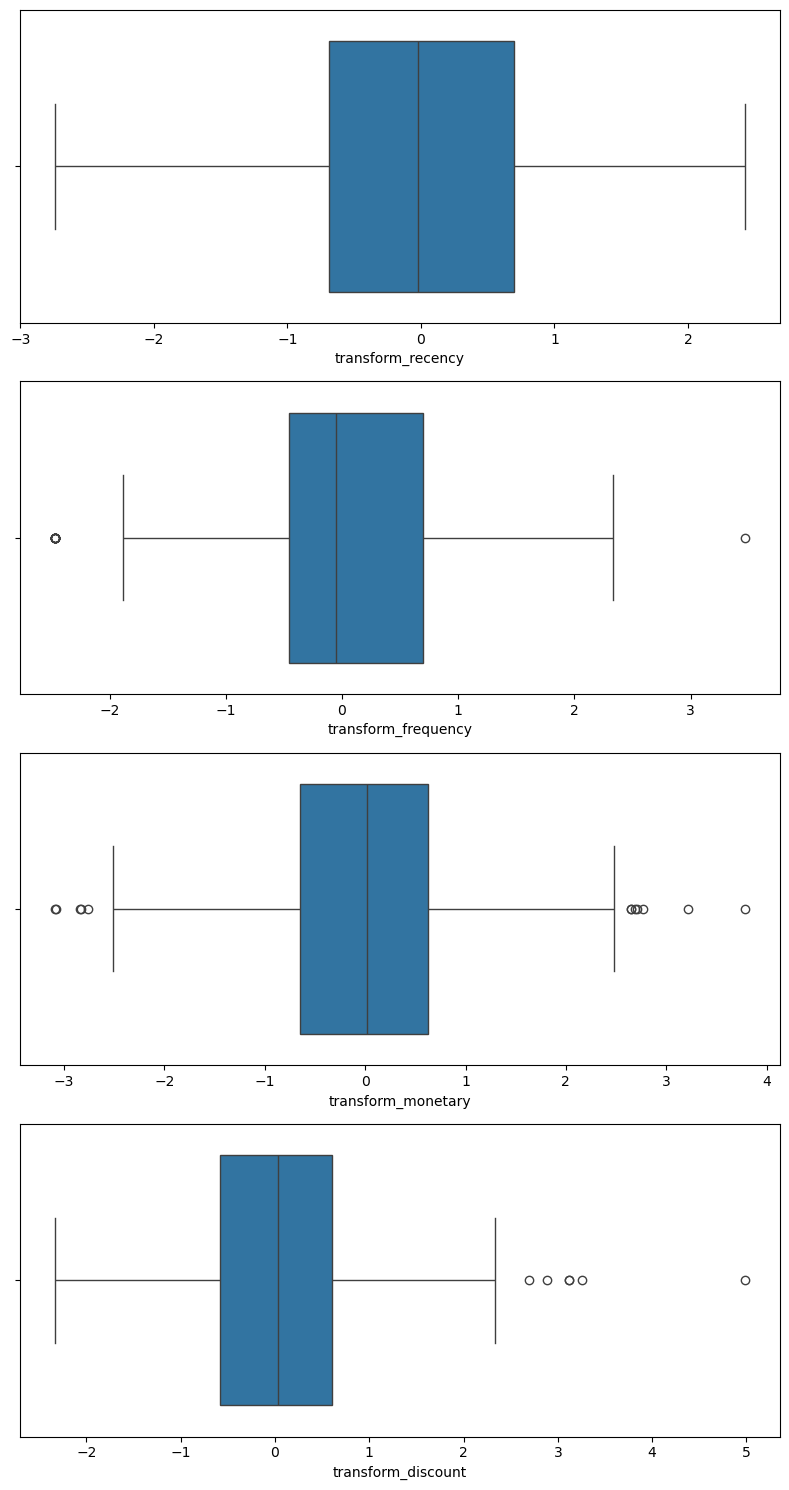

In [79]:
numerical_dis_plot(
    features=["transform_recency", "transform_frequency", "transform_monetary", "transform_discount"],
    df=transformed_kmeans_df,
)

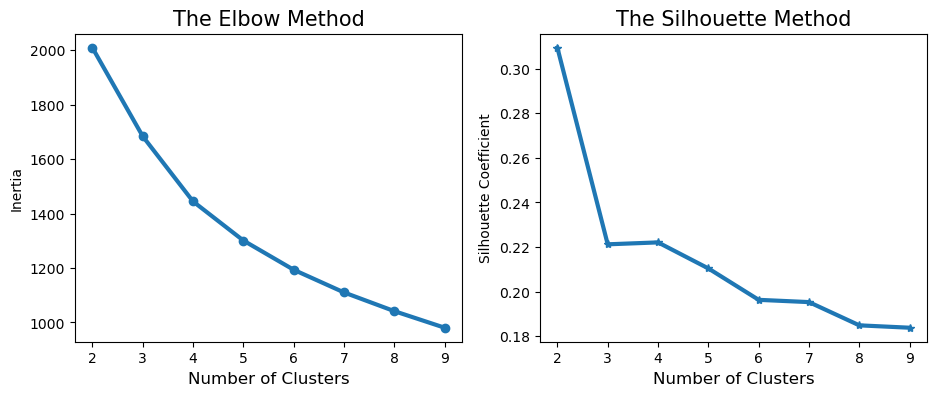

In [82]:
inertia = {}
silhouette = {}
 
for k in range(2,10):
    model = KMeans(n_clusters = k, random_state=75)
    model.fit_predict(transformed_kmeans_df)
    inertia[k]= model.inertia_ # Calculate the inertia
    silhouette[k]= silhouette_score(transformed_kmeans_df, model.labels_) # Calculate the silhouette coefficient
 
fig, axs = plt.subplots(1,2, figsize = (11,4))
axs[0].plot(inertia.keys(), inertia.values(), marker = 'o', lw = 3)
axs[0].set_xlabel('Number of Clusters', fontsize = 12)
axs[0].set_ylabel('Inertia')
axs[0].set_title('The Elbow Method', fontsize = 15)
 
axs[1].plot(inertia.keys(), silhouette.values(), marker = '*' , lw = 3)
axs[1].set_xlabel('Number of Clusters', fontsize = 12)
axs[1].set_ylabel('Silhouette Coefficient')
axs[1].set_title('The Silhouette Method', fontsize = 15)
plt.show() 

In [83]:
K = 4
 
model = KMeans(n_clusters=K, random_state=75)
model.fit(transformed_kmeans_df)
 
joblib.dump(model, "kmeans_clustering_model.joblib")

['kmeans_clustering_model.joblib']

In [84]:
clusters = model.predict(transformed_kmeans_df)
 
kmeans_df["customer_segment"] = clusters.astype(str)
kmeans_df.sample(5)

/var/folders/kp/1yj5j5nx6gddj5pqbjbnl45r0000gn/T/ipykernel_60023/944008224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_df["customer_segment"] = clusters.astype(str)


,customer_id,recency,frequency,monetary,discount,customer_segment
658,RS-19765,36,8,4159.770,129.2016,2
422,KD-16270,484,5,8282.358,1201.4704,0
86,BG-11695,36,6,1874.172,598.1408,2
461,LH-16900,21,9,2295.332,126.7514,2
202,DE-13255,719,5,2550.874,22.7904,1


### Segmentation Analysis

In [85]:
result_kmeans_df = pd.merge(
    left=main_df,
    right=kmeans_df[["customer_id", "customer_segment"]],
    on="customer_id",
    how="inner"
)
result_kmeans_df.head(5)

,customer_id,max_order_timestamp,ship_mode,type_customers,category,region,frequency,monetary,discount,recency,customer_segment
0,AA-10315,2017-06-29,Standard Class,Consumer,Office Supplies,Central,5,5563.560,1015.92800,184,0
1,AA-10375,2017-12-11,Standard Class,Consumer,Office Supplies,East,9,1056.390,34.54400,19,2
2,AA-10480,2017-04-15,Standard Class,Consumer,Office Supplies,Central,4,1790.512,3.11040,259,3
3,AA-10645,2017-11-05,Standard Class,Consumer,Furniture,East,6,5086.935,532.18395,55,0
4,AB-10015,2016-11-10,First Class,Consumer,Office Supplies,Central,3,886.156,12.26720,415,3


In [86]:
result_kmeans_df['customer_segment'] = pd.Categorical(result_kmeans_df['customer_segment'], [
    "0", "1", "2", "3"
])

<Axes: xlabel='count', ylabel='customer_segment'>

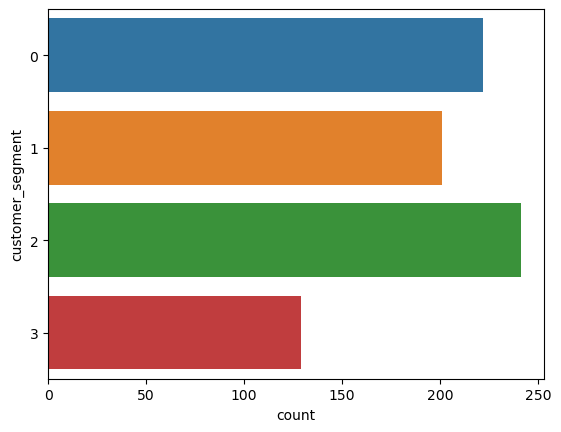

In [88]:
sns.countplot(data=result_kmeans_df, y='customer_segment', hue = 'customer_segment') 

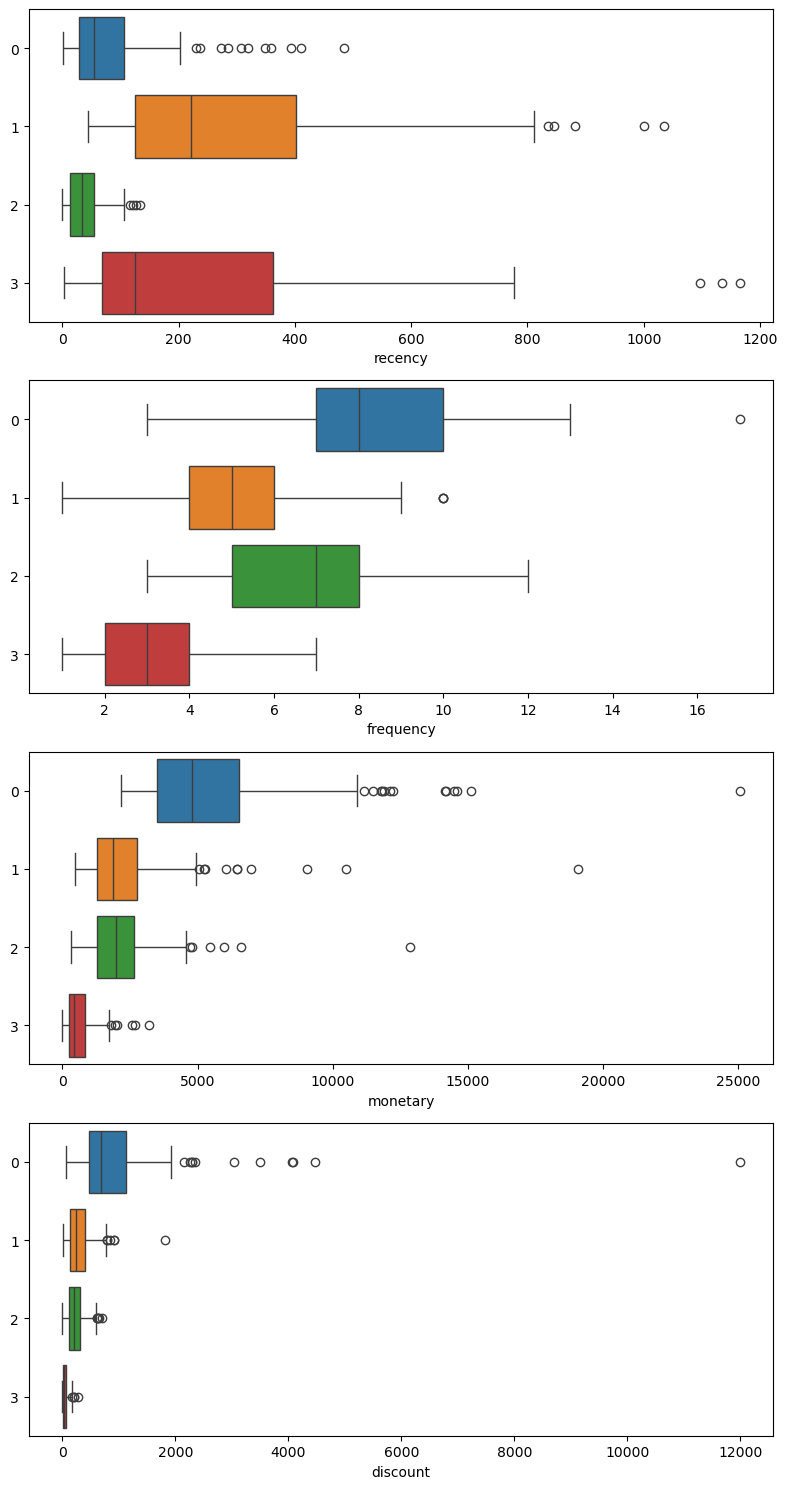

In [89]:
numerical_dis_plot(
    features=["recency", "frequency", "monetary", "discount"], 
    df=result_kmeans_df, 
    segment_feature="customer_segment"
)

- Klaster 0: merupakan kelompok top customers yang sangat loyal dan cenderung melakukan transaksi dalam jumlah besar serta sering menggunakan discount.
- Klaster 1: merupakan kelompok medium value customers. 
- Klaster 2: merupakan kelompok high value customers yang sering melakukan transaksi dan memiliki potensi sangat besar untuk menjadi top customers.
- Klaster 3: merupakan kelompok low value customers yang jarang melakukan transaksi dan berpotensi untuk melakukan churn.